# Create Baselines

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

In [7]:
bool_wb = xr.open_dataset(data_dir / "RUNOFF/bool_water_balance_20pct.nc")
bool_wb = bool_wb.to_array().isel(variable=0).drop("variable")
bool_wb

<xarray.DataArray (station_id: 671)>
array([False,  True, False, False,  True,  True, False, False, False,
        True, False, False, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True, False,  True,  True,
        True, False, False,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False, False,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  

# Read in AWS Models

In [8]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "runs/ensemble/data_ENS.csv")
ealstm_ensemble_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_ensemble_df["time"] = pd.to_datetime(ealstm_ensemble_df["time"])
ealstm_preds = ealstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [9]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet_trainperiod/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

# Fuse Data

In [10]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [11]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [12]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

# Match Station / Times

In [13]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Join all models

In [14]:
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds

In [47]:
!git pull
# BENCHMARKS
# 1) Persistence
all_preds["persistence"] = ds["discharge_spec"].shift(time=1).sel(station_id=all_preds.station_id, time=all_preds.time)

# 2) DayofYear Climatology
from src.utils import create_shape_aligned_climatology

climatology_unit = "month"

climatology_doy = ds["discharge_spec"].groupby("time.dayofyear").mean()
climatology_doy = create_shape_aligned_climatology(ds, climatology_doy.to_dataset(), variable="discharge_spec", time_period="dayofyear")

climatology_mon = ds["discharge_spec"].groupby("time.month").mean()
climatology_mon = create_shape_aligned_climatology(ds, climatology_mon.to_dataset(), variable="discharge_spec", time_period="month")
    
all_preds["climatology_doy"] = climatology_doy.sel(station_id=all_preds.station_id, time=all_preds.time)["discharge_spec"]
all_preds["climatology_mon"] = climatology_mon.sel(station_id=all_preds.station_id, time=all_preds.time)["discharge_spec"]

all_preds

Already up to date.


<xarray.Dataset>
Dimensions:          (station_id: 519, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    TOPMODEL         (station_id, time) float64 ...
    ARNOVIC          (station_id, time) float64 ...
    PRMS             (station_id, time) float64 ...
    SACRAMENTO       (station_id, time) float64 ...
    EALSTM           (station_id, time) float64 1.719 2.034 ... 1.076 1.041
    obs              (station_id, time) float64 2.14 1.81 4.57 ... 2.53 2.33
    LSTM             (station_id, time) float64 1.526 1.759 2.45 ... 1.536 1.48
    persistence      (time, station_id) float64 3.49 3.08 3.62 ... 0.42 1.2 2.53
    climatology      (time, station_id) float64 2.735 3.358 ... 3.557 5.545
    climatology_mon  (time, station_id) float64 2.735 3.358 ... 3.557 5.545
    climatology_doy  (time, station_id) float64 3.111 3.372 3.54 ... 2.833 4.293

# ALL Errors

In [48]:
# if "all_errors" not in globals().keys():
all_errors = calculate_all_data_errors(all_preds)
all_metrics = get_metric_dataframes_from_output_dict(all_errors)
all_metrics.keys()

Errors: 100%|██████████| 10/10 [01:55<00:00, 11.57s/it]


dict_keys(['nse', 'kge', 'mse', 'bias', 'log_nse', 'inv_kge', 'abs_pct_bias', 'mape', 'mam30_ape', 'rmse'])

In [49]:
display(all_errors["climatology_doy"].median())
display(all_errors["climatology_mon"].median())

nse              0.144906
kge              0.126402
mse              3.013507
bias            -7.401608
log_nse          0.211774
inv_kge          0.189864
abs_pct_bias     7.468998
mape            89.847798
mam30_ape       69.388112
rmse             3.013507
dtype: float64

nse              0.122522
kge              0.088534
mse              3.073340
bias            -7.404490
log_nse          0.198275
inv_kge          0.147047
abs_pct_bias     7.450275
mape            91.716052
mam30_ape       76.158394
rmse             3.073340
dtype: float64

# CDF Plotting

In [112]:
from typing import Optional, List, Tuple

ml_sids = all_metrics["nse"].index.values

def plot_cdf(
    error_data, metric: str = "", 
    sids: List[int] = ml_sids, 
    clip: Optional[Tuple] = None, 
    ax = None, 
    title=None,
    models: Optional[List[str]] = None,
):
    colors = sns.color_palette()
    kwargs_dict = {
        "TOPMODEL": {"linewidth": 1, "alpha":0.8, "color": colors[2], "clip": clip},
        "PRMS": {"linewidth": 1, "alpha":0.8, "color": colors[3], "clip": clip},
        "ARNOVIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "VIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "SACRAMENTO": {"linewidth": 1, "alpha":0.8, "color": colors[5], "clip": clip},
        "gr4j": {"linewidth": 1, "alpha":0.8, "color": colors[9], "clip": clip},
        "climatology": {"linewidth": 1, "alpha":0.8, "color": colors[6], "clip": clip, "ls": "-."},
        "climatology_doy": {"linewidth": 1, "alpha":0.8, "color": colors[6], "clip": clip, "ls": "-."},
        "climatology_mon": {"linewidth": 1, "alpha":0.8, "color": colors[8], "clip": clip, "ls": "-."},
        "persistence": {"linewidth": 1, "alpha":0.8, "color": colors[7], "clip": clip, "ls": "-."},
        "EALSTM": {"linewidth": 3, "alpha": 1, "color": colors[1], "clip": clip},
        "LSTM": {"linewidth": 3, "alpha": 1, "color": colors[0], "clip": clip},
    }
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
    
    if models is None:
        models = [c for c in error_data.columns if c in kwargs_dict]
    for ix, model in enumerate(models):
        sns.kdeplot(
            error_data[model].dropna(),
            cumulative=True,
            legend=False, ax=ax,
            label=f"{model}: {error_data[model].median():.2f}",
            **kwargs_dict[model]
        )

        ax.axvline(error_data[model].dropna().median(), ls="--", color=kwargs_dict[model]["color"])

    ax.set_xlim(clip)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cumulative density")
    title = title if title is not None else f"Cumuluative Density Function of Station {metric} Scores"
    ax.set_title(title)
    sns.despine()
    plt.legend()
    
    return ax

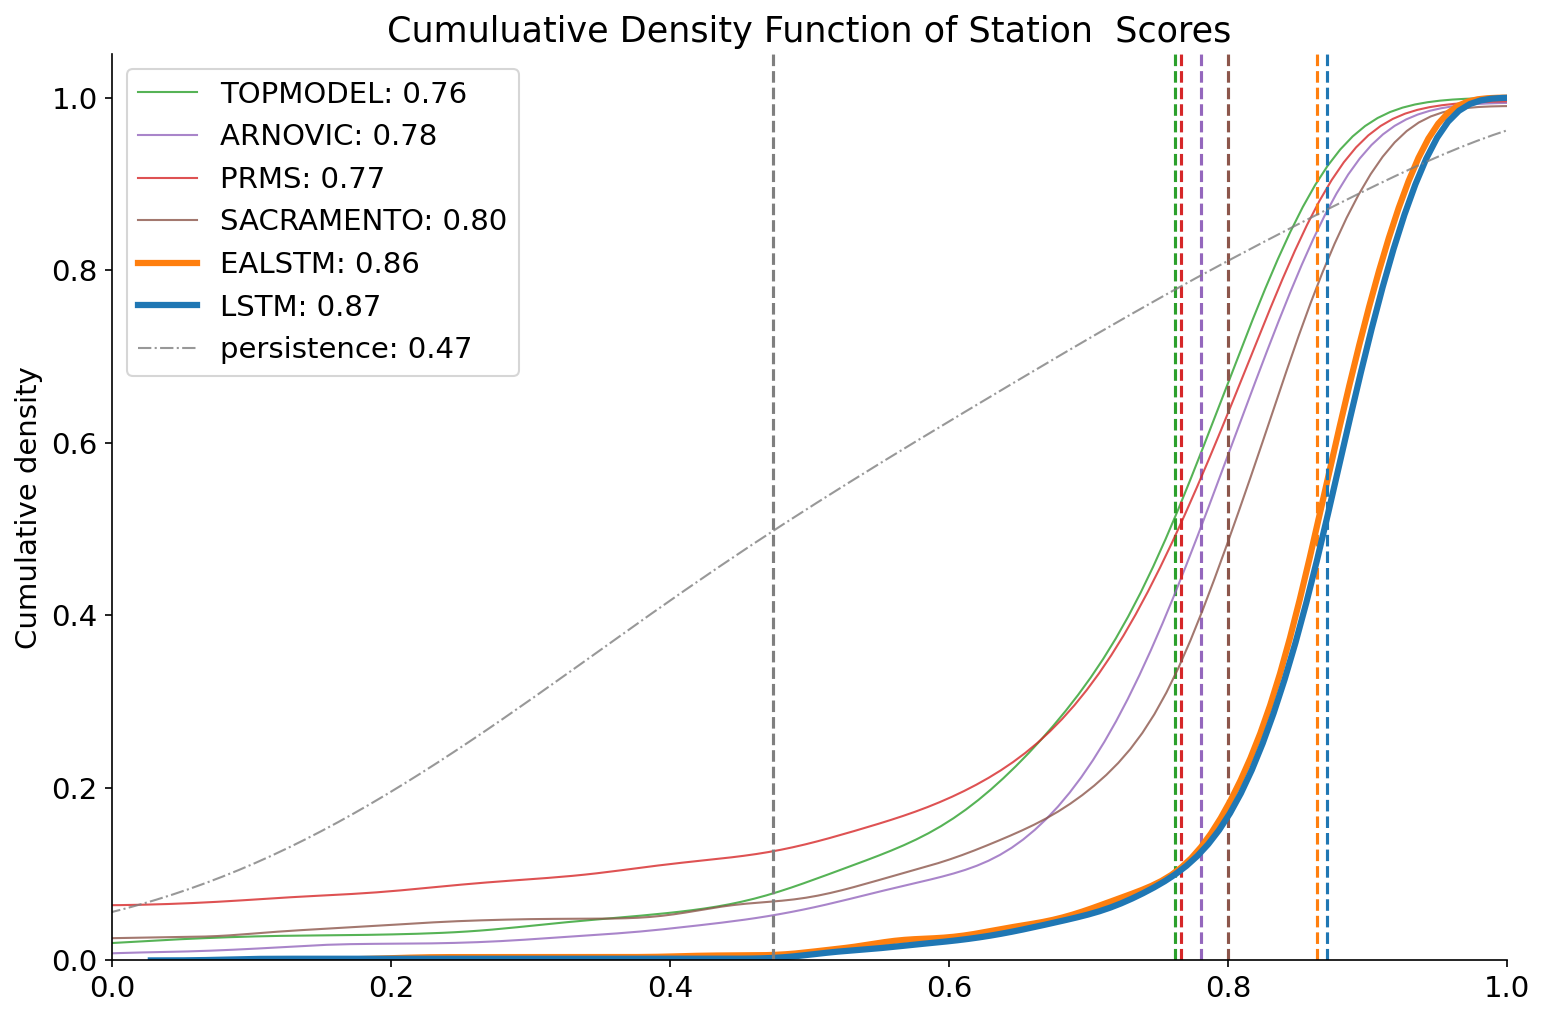

In [58]:
models = None

f, ax = plt.subplots(figsize=(12, 8))
plot_cdf(all_metrics["nse"], clip=(0, 1), ax=ax, models=models);

In [ ]:
# Our own efficiency metric rather than calibrating on the mean = (variance)
1 - ( / )

# Spatial Data

In [17]:
import geopandas as gpd

shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

# points_gdf = 
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

In [18]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

uk = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

# Read in GR4J Models

In [116]:
csvs = list((data_dir / "GR4J_data/single").glob("HD_FlowSingle*.csv"))
metadata = pd.read_csv(list((data_dir / "GR4J_data/single").glob("ALL*.csv"))[0], index_col=0)
metadata = metadata.set_index("catchID")
print(metadata.columns)

Index(['River', 'Station', 'param1', 'param2', 'param3', 'param4',
       'Thresh_Met', 'NSE_Cal', 'NSElog_Cal', 'MAPE_Cal', 'absPBIAS_Cal',
       'MAM30APE_Cal', 'Q95APE_Cal', 'Eval_Yrs', 'NSE_Eval', 'NSElog_Eval',
       'MAPE_Eval', 'absPBIAS_Eval', 'MAM30APE_Eval', 'Q95APE_Eval',
       'UncertWidth_500', 'ContRatio_500'],
      dtype='object')


In [139]:
gr4j_df = pd.concat([
    pd.read_csv(csv, index_col=0).rename(
        {"catchID": "station_id", "Date": "time", "Flow_Top_Calib": "sim", "Max_500": "ensemble_upper", "Min_500": "ensemble_lower"}, 
        axis=1
    ).astype({"time": "datetime64[ns]"})
    for csv in csvs
])

gr4j_df.head()

,station_id,time,sim,ensemble_lower,ensemble_upper
0,10002,1891-01-01,8.319,4.557,13.492
1,10002,1891-01-02,6.847,4.141,11.252
2,10002,1891-01-03,6.112,4.037,9.891
3,10002,1891-01-04,6.026,4.267,9.770
4,10002,1891-01-05,6.326,4.524,9.220


In [140]:
gr4j = gr4j_df.set_index(["station_id", "time"]).to_xarray()
obs = ds["discharge_spec"].sel(station_id=np.isin(ds.station_id.values, gr4j.station_id.values), time=np.isin(ds.time, gr4j.time)).rename("obs")

In [145]:
gr4j = gr4j.sel(station_id=obs.station_id, time=obs.time).merge(obs)

<xarray.Dataset>
Dimensions:         (station_id: 259, time: 4018)
Coordinates:
  * station_id      (station_id) int64 3003 6007 6008 7001 ... 94001 96001 96002
  * time            (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    sim             (station_id, time) float64 19.3 20.3 65.59 ... 8.153 7.496
    ensemble_lower  (station_id, time) float64 17.04 11.24 22.39 ... 2.573 2.39
    ensemble_upper  (station_id, time) float64 36.2 34.12 145.4 ... 19.83 18.46
    obs             (time, station_id) float64 3.94 4.54 4.62 ... 3.85 0.97 1.1

In [156]:
# lstm_preds.sel(station_id=np.isin(lstm_preds.station_id.values, [int(i) for i in metadata.index]))

gr4j_lstm_preds = lstm_ensemble.sel(station_id=np.isin(lstm_ensemble.station_id.values, gr4j.station_id.values))
gr4j_lstm_preds = (gr4j_lstm_preds.rename({"sim": "LSTM"}))

all_gr4j = gr4j.sel(time=gr4j_lstm_preds.time).rename({"sim": "gr4j"}).drop(["ensemble_lower","ensemble_upper"]).merge(gr4j_lstm_preds.drop("obs"))

In [157]:
lstm_gr4j_errors = calculate_all_data_errors(all_gr4j)
lstm_gr4j_metrics = get_metric_dataframes_from_output_dict(lstm_gr4j_errors)
lstm_gr4j_errors = lstm_gr4j_errors["lstm"]

Errors: 100%|██████████| 2/2 [00:08<00:00,  4.39s/it]


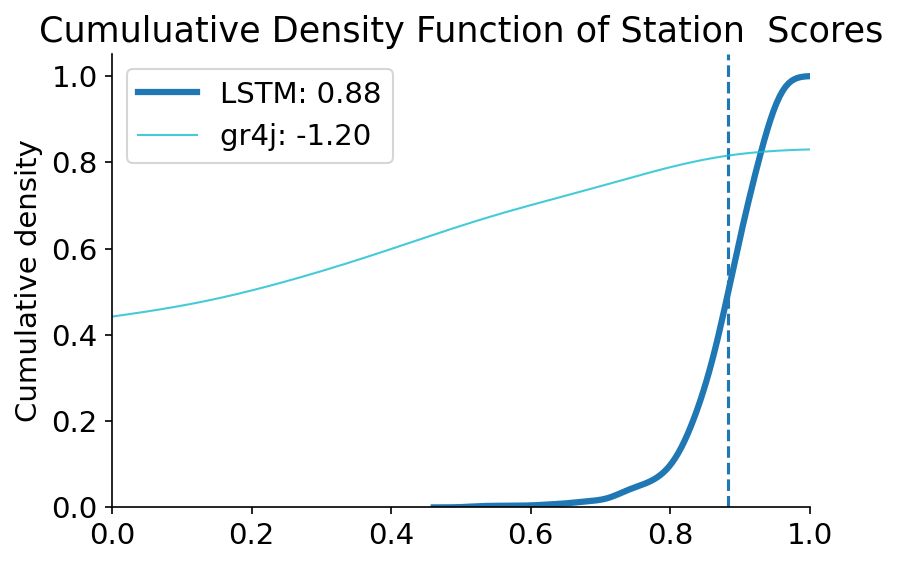

In [158]:
nse_data = lstm_gr4j_metrics["nse"]
f, ax = plt.subplots();
plot_cdf(nse_data, clip=(0, 1), ax=ax, models=["LSTM", "gr4j"]);

In [160]:
# nse_data